transfer learning between a 1Dgamma and a 1Dgamma function with fixed parameters.

In [1]:
from scipy.special import kl_div,rel_entr
import numpy as np
from matplotlib import pyplot
import quantum_classical_1Dgamma as qc
from matplotlib.offsetbox import AnchoredText
import pandas as pd
from scipy import stats
import tensorflow as tf
from matplotlib import pyplot
from matplotlib import pyplot as plt
from qibo import gates, hamiltonians, models, set_backend, set_threads
import seaborn as sns

[Qibo 0.1.7|INFO|2022-07-03 16:10:09]: Using tensorflow backend on /device:CPU:0
[Qibo 0.1.7|WARNING|2022-07-03 16:10:09]: qibotf library was not found. `tf.einsum` will be used to apply gates. In order to install Qibo's high performance custom operators for TensorFlow please use `pip install qibotf`. Alternatively, consider installing the qibojit backend.
[Qibo 0.1.7|INFO|2022-07-03 16:10:10]: Using tensorflow backend on /device:CPU:0
[Qibo 0.1.7|WARNING|2022-07-03 16:10:10]: `set_threads` is not supported by the tensorflow backend. Please use tensorflow's thread setters: `tf.config.threading.set_inter_op_parallelism_threads` or `tf.config.threading.set_intra_op_parallelism_threads` to switch the number of threads.


In [2]:
def kl_divergence(bins_real, bins_fake,epsilon):
    
    epsilon=0.1
    prob_real=[]
    prob_fake=[]
    for i in range (len(bins_real)):
        prob_real.append(bins_real[i]+epsilon)
        prob_fake.append(epsilon+bins_fake[i])

    #print(prob_fake,prob_real)  

    prob_real=prob_real/sum(prob_real) # probability for each bin (Normalization)
    prob_fake=prob_fake/sum(prob_fake)

   
    return sum(prob_real[i] * np.log(prob_real[i]/prob_fake[i]) for i in range(len(prob_real)))# Convergence problem if a[i] or b[i] equals zero. 
                                                            #I add a little quantity to each bin to avoid problems



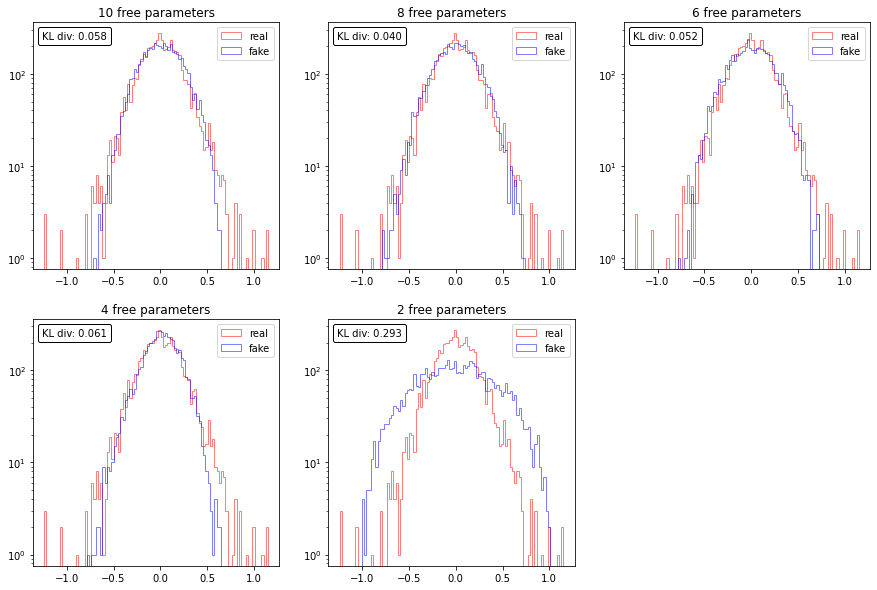

In [3]:
# number of qubits generator
nqubits = 1
# create hamiltonians
def hamiltonian1():
        m0 = hamiltonians.Z(1).matrix
        ham = hamiltonians.Hamiltonian(1, m0)
        return ham
hamiltonian1 = hamiltonian1()
fixed_params = range(0,10,2)
latent_dim=3
samples=5000
nqubits=1
layers=2
rows=2
cols=3
# create quantum generator
circuit = models.Circuit(nqubits)
for l in range(layers):
    for q in range(nqubits):
        circuit.add(gates.RY(q, 0))
        circuit.add(gates.RZ(q, 0))
for q in range(nqubits):
    circuit.add(gates.RY(q, 0)) 
    
pyplot.figure(figsize=(15, 10))

s=qc.generate_training_real_samples(samples)
x_real, y_real = qc.generate_real_samples(samples, s, 3000)

distributions=[]
kl = []
kl.append("---")
distributions.append(x_real)
for i, val in enumerate(fixed_params):
    params = np.loadtxt(f"iterator/PARAMS_1Dgamma_logistic_1_3_2_10000_128_0.1_fixed_params_{val}_0", delimiter=' ', unpack='true')
    
    params = tf.Variable(params)
    #print(params)
    x_fake, y_fake = qc.generate_fake_samples(params, latent_dim, samples, circuit, nqubits, layers, hamiltonian1,val)
    distributions.append(x_fake)
    #x_fake,_= qc2.generate_fake_samples(params, latent_dim, samples)
    #s=qc.generate_training_real_samples(samples)
    #x_real, y_real = qc.generate_real_samples(samples, s, 3000)

    nbins=100
    pyplot.subplot(rows,cols,i+1)
    #pyplot.figure(figsize=(14, 7))
    bins_real=pyplot.hist(x_real, color='red', bins=nbins,histtype='step',label='real', alpha=0.5)
    bins_fake=pyplot.hist(x_fake.numpy(), bins=bins_real[1],histtype='step',color='blue', label='fake', alpha=0.5)
    ax=pyplot.gca()
    kl.append(kl_divergence(bins_real[0],bins_fake[0],epsilon=0.1))
    at = AnchoredText(
    f"KL div: {'%.3f' %kl_divergence(bins_real[0],bins_fake[0],epsilon=0.1)}", prop=dict(size=10), frameon=True, loc='upper left')
    at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
    ax.add_artist(at)
    #pyplot.text( 0.,0.,"prova", bbox=dict(facecolor='red', alpha=0.5))
    #pyplot.xlim(-1,1)
    pyplot.yscale('log')
    pyplot.title(f'{10-val} free parameters')
    pyplot.legend()
pyplot.show()

In [4]:
stat_moments_mean= [[] for i in range(4)]
stat_moments_err= [[] for i in range(4)]
samples = 1000
for i, val in enumerate(fixed_params):
    
    moments = [[] for j in range(4)]
    for k in range(4):
        params = np.loadtxt(f"iterator/PARAMS_1Dgamma_logistic_1_3_2_10000_128_0.1_fixed_params_{val}_{k}", delimiter=' ', unpack='true')
    
        params = tf.Variable(params)
        x_fake, _ = qc.generate_fake_samples(params, latent_dim, samples, circuit, nqubits, layers, hamiltonian1,val)
        
        moments[0].append(np.mean(x_fake))
        moments[1].append(stats.moment(x_fake,moment=2)[0])
        moments[2].append(stats.moment(x_fake,moment=3)[0])
        moments[3].append(stats.moment(x_fake,moment=4)[0])
        
    for k in range(len(moments)): 
        
        stat_moments_mean[k].append(np.mean(moments[k]))
        stat_moments_err[k].append(stats.moment(moments[k],moment=2))
        
print(stat_moments_mean, stat_moments_err)

[[-0.004732389834511174, 0.00015051293414867356, -0.002445440269210759, -0.004147324816496544, 0.014934344388420787], [0.052393584858602266, 0.10630700145949093, 0.05183735546067399, 0.040268048392526914, 0.1543334943747354], [-0.0007178854519740883, -0.00019418490667080465, 0.00047646157010095583, -0.0013740032875290127, -0.0029226177395422614], [0.007723240465938324, 0.04118376810874589, 0.007586542354970774, 0.005792807826198348, 0.058691367792760074]] [[0.00012967093963054318, 0.0001185970842226898, 4.164707854162544e-05, 8.495702399245126e-05, 0.00013723417373447632], [3.054078797007973e-05, 0.006305016241612627, 3.983470079755963e-05, 4.04498963626984e-06, 9.940759668820027e-06], [2.3470492663116997e-07, 1.343230529041349e-06, 1.0152467955704922e-07, 1.0187219259975885e-06, 7.675673871957997e-06], [1.8351021228739143e-06, 0.002825400648071874, 3.1994003581495768e-06, 2.838058025473547e-07, 1.8937250277906909e-06]]


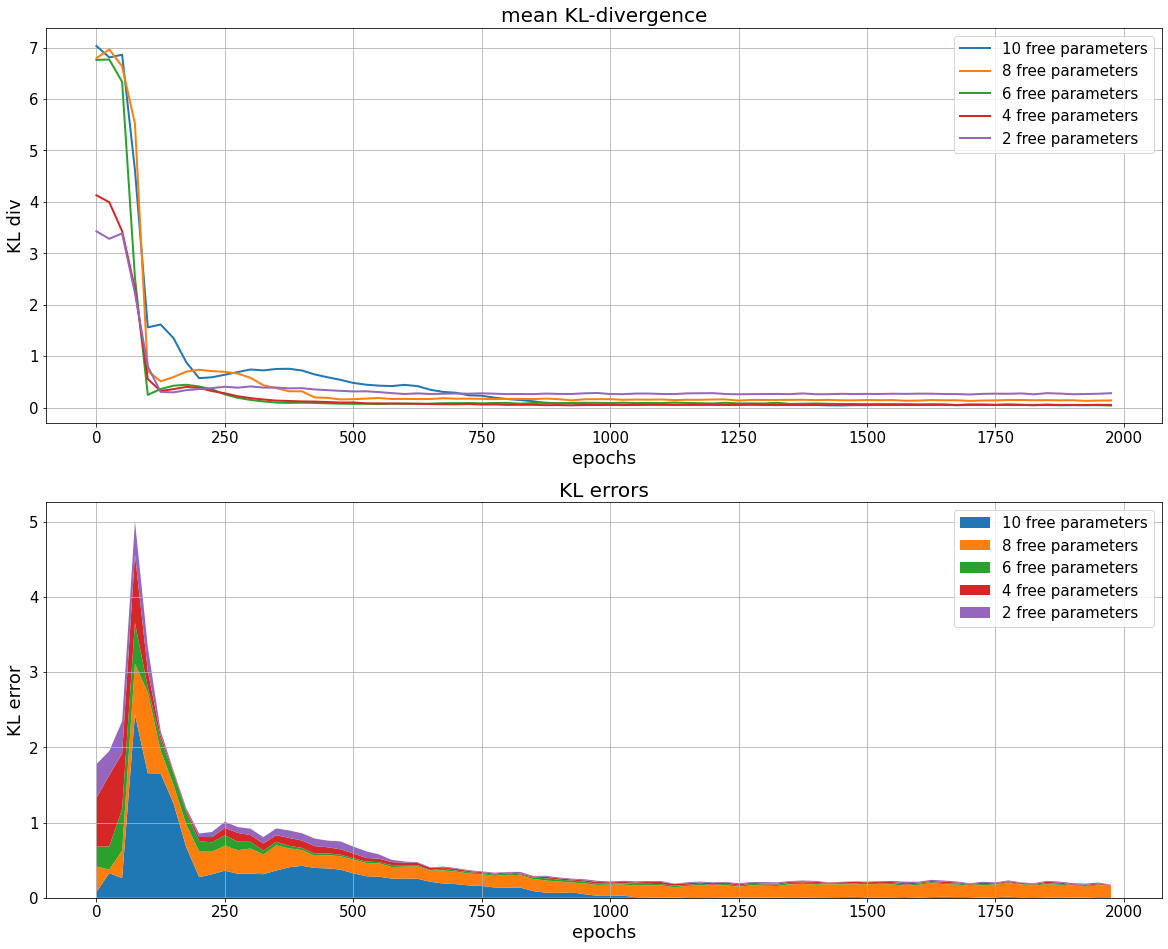

In [5]:
errors=[]
fixed_params=range(0,10,2)
epochs=range(0,2000,25)
plt.figure(figsize=(20,16))
plt.subplot(2,1,1)

#fig, ax = plt.subplots(figsize=(20,7))
kl_mean = ["---"]
kl_error = ["---"]
kl_data=[[] for i in range(len(fixed_params))]


for i, val in enumerate(fixed_params):
    
    kl_transfer_learning=[]
    for j in range (4):
        kl=np.loadtxt(f"iterator/KLdiv_1Dgamma_logistic_1_3_2_10000_128_0.1_{val}_{j}")
        kl_data[i].append(kl[-1])
        
        kl_transfer_learning.append(kl)
        
    mean=np.mean(kl_transfer_learning, axis=0)
    
    error=np.std(kl_transfer_learning, axis=0)
    errors.append(error)
    kl_mean.append(mean[len(mean)-1])
    kl_error.append(error[len(mean)-1])
    pyplot.plot(epochs,mean,color=f"C{i}",label=f'{10-val} free parameters',linewidth=2,alpha=1)


pyplot.title(f'mean KL-divergence', fontsize=20)
    
pyplot.xlabel('epochs', fontsize=18)
pyplot.ylabel('KL div',fontsize=18)
pyplot.legend(fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
pyplot.grid()

# plot errors of KL 

plt.subplot(2,1,2)

labels=[f'{10-val} free parameters' for val in fixed_params]

ax = plt.gca()   
ax.stackplot(epochs, errors,labels=labels)
pyplot.legend(fontsize=15)
pyplot.title("KL errors",fontsize=20)
pyplot.xlabel("epochs",fontsize=18)
pyplot.ylabel("KL error",fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
pyplot.grid()
pyplot.show()
plt.show()

In [6]:
kl_mean[0]

'---'

In [7]:
time_mean=["---"]
time_error=["---"]
t=[[] for i in range (len(fixed_params))]
for i,val in enumerate(fixed_params):
    
    for j in range(4):
        t[i].append(np.loadtxt(f"iterator/1/time_1Dgamma_1_3_2_10000_128_0.1_fixed_params_{val}_{j}"))
    
    time_mean.append(int(np.mean(t[i] )))
    
    time_error.append(int(stats.moment(t[i],moment=2)**(1/2)))
    


In [8]:
x=[]
y=[]
for i,val in enumerate(t):
    
    for j in range(len(val)):
        x.append(10-2*i)
        y.append(int(val[j]))
        
x1=[]
y1=[]
for i,val in enumerate(kl_data):
   
    for j in range(len(val)):
        x1.append(10-2*i)
        y1.append(float(val[j]))


In [9]:
print(np.mean(distributions[0]))
stat_moments_mean[0]

0.0035755701340608056


[-0.004732389834511174,
 0.00015051293414867356,
 -0.002445440269210759,
 -0.004147324816496544,
 0.014934344388420787]

In [10]:
print(*stat_moments_err[0])

0.00012967093963054318 0.0001185970842226898 4.164707854162544e-05 8.495702399245126e-05 0.00013723417373447632


In [11]:
from IPython.display import display
# fake 10 = fake distribution with 10 free parameters
moments = pd.DataFrame(
    {
        "distribution":["real","fake 10","fake 8 ", "fake 6 ", "fake 4 ","fake 2" ],
        "mean":[np.mean(distributions[0]), *stat_moments_mean[0]],
        "2 moment":[stats.moment(distributions[0],moment=2)[0] , *stat_moments_mean[1] ],
        "3 moment":[stats.moment(distributions[0],moment=3)[0] , *stat_moments_mean[2] ],
        "4 moment":[stats.moment(distributions[0],moment=4)[0] , *stat_moments_mean[3] ],
        "mean error":["---", *stat_moments_err[0]],
        "2 moment error":["---" , *stat_moments_err[1] ],
        "3 moment error":["---" , *stat_moments_err[2] ],
        "4 moment error":["---" , *stat_moments_mean[3] ],
        "kl mean": [*kl_mean],
        "kl error": [*kl_error],
        "time mean (s)":[*time_mean],
        "time error (s)":[*time_error],
    }
)
display(moments)

,distribution,mean,2 moment,3 moment,4 moment,mean error,2 moment error,3 moment error,4 moment error,kl mean,kl error,time mean (s),time error (s)
0,real,0.003576,0.053914,0.000277,0.012821,---,---,---,---,---,---,---,---
1,fake 10,-0.004732,0.052394,-0.000718,0.007723,0.00013,0.000031,0.0,0.007723,0.044943,0.008245,8071,1205
2,fake 8,0.000151,0.106307,-0.000194,0.041184,0.000119,0.006305,0.000001,0.041184,0.139966,0.153327,7473,1092
3,fake 6,-0.002445,0.051837,0.000476,0.007587,0.000042,0.00004,0.0,0.007587,0.048336,0.004885,6595,312
4,fake 4,-0.004147,0.040268,-0.001374,0.005793,0.000085,0.000004,0.000001,0.005793,0.053766,0.005935,5899,213
5,fake 2,0.014934,0.154333,-0.002923,0.058691,0.000137,0.00001,0.000008,0.058691,0.281368,0.003084,5146,252


In [12]:
moments_without_error = pd.DataFrame(
    {
        "distribution":["real","fake 10","fake 8 ", "fake 6 ", "fake 4 ","fake 2" ],
        "mean":[np.mean(distributions[0]), *stat_moments_mean[0]],
        "2 moment":[stats.moment(distributions[0],moment=2)[0] , *stat_moments_mean[1] ],
        "3 moment":[stats.moment(distributions[0],moment=3)[0] , *stat_moments_mean[2] ],
        "4 moment":[stats.moment(distributions[0],moment=4)[0] , *stat_moments_mean[3] ],
        "kl mean": [*kl_mean],
        "kl error": [*kl_error],
        "time mean (s)":[*time_mean],
        "time error (s)":[*time_error],
    }
)
display(moments_without_error)

,distribution,mean,2 moment,3 moment,4 moment,kl mean,kl error,time mean (s),time error (s)
0,real,0.003576,0.053914,0.000277,0.012821,---,---,---,---
1,fake 10,-0.004732,0.052394,-0.000718,0.007723,0.044943,0.008245,8071,1205
2,fake 8,0.000151,0.106307,-0.000194,0.041184,0.139966,0.153327,7473,1092
3,fake 6,-0.002445,0.051837,0.000476,0.007587,0.048336,0.004885,6595,312
4,fake 4,-0.004147,0.040268,-0.001374,0.005793,0.053766,0.005935,5899,213
5,fake 2,0.014934,0.154333,-0.002923,0.058691,0.281368,0.003084,5146,252


In [13]:
print(moments_without_error.to_latex(index=False))  

\begin{tabular}{lrrrrllll}
\toprule
distribution &      mean &  2 moment &  3 moment &  4 moment &   kl mean &  kl error & time mean (s) & time error (s) \\
\midrule
        real &  0.003576 &  0.053914 &  0.000277 &  0.012821 &       --- &       --- &           --- &            --- \\
     fake 10 & -0.004732 &  0.052394 & -0.000718 &  0.007723 &  0.044943 &  0.008245 &          8071 &           1205 \\
     fake 8  &  0.000151 &  0.106307 & -0.000194 &  0.041184 &  0.139966 &  0.153327 &          7473 &           1092 \\
     fake 6  & -0.002445 &  0.051837 &  0.000476 &  0.007587 &  0.048336 &  0.004885 &          6595 &            312 \\
     fake 4  & -0.004147 &  0.040268 & -0.001374 &  0.005793 &  0.053766 &  0.005935 &          5899 &            213 \\
      fake 2 &  0.014934 &  0.154333 & -0.002923 &  0.058691 &  0.281368 &  0.003084 &          5146 &            252 \\
\bottomrule
\end{tabular}



/var/folders/s2/82sd15fd5zx5zvjy5hnfkg1m0000gn/T/ipykernel_2911/591216388.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(moments_without_error.to_latex(index=False))


confrontare con i simple learning 

In [14]:
# load simple learning distributions (10 params is not considered )

simple_distr = []
for i in range(8,0,-2):
    simple_distr.append(np.loadtxt(f"fake_data_{i}.dat"))

# calculate KL
simple_kl = []

for i,val in enumerate(simple_distr):
    
    
    #bins_real=np.histogram(distributions[i+2], bins=nbins)
    bins_real=np.histogram(x_real, bins=nbins)
    bins_fake=np.histogram(val, bins=bins_real[1])
    
    simple_kl.append(kl_divergence(bins_real[0],bins_fake[0],epsilon=0.1))

# load times
simple_t = []

for i in range(8,0,-2):
    simple_t.append(int(np.loadtxt(f"time_{i}.dat")))
    
print(simple_kl)  
print(simple_t)

[0.05047222766453188, 0.056689882427829325, 6.234679657401932, 0.04524791983402772]
[8533, 7726, 6719, 8289]


In [15]:
moments_8 = [0.0021345544188169454, 0.05647741259272729, 6.34309902303998e-05, 0.008758459043650682] 
err_moments_8 = [1.2964741757028036e-05, 4.1201639235320846e-05, 9.152030435022186e-07, 3.3019128067238724e-06]

moments_6 = [0.0011522139688009076, 0.0596537637990496, 0.0004107499016447275, 0.00977206939309596] 
err_moments_6 = [0.00018570325490616427, 5.981681157163635e-06, 1.944174780549571e-06, 5.570743005273505e-07]

moments_4 = [-0.1348912985994853, 2.407412430484045e-34, -6.01372059770744e-51, 1.576412614042154e-67] 
err_moments_4 = [0.008106308585401642, 9.968491529972445e-68, 7.991982149981532e-101, 6.354573367669861e-134]

moments_2 = [-0.0003378647686086728, 0.17255631035423036, -0.003458096198881845, 0.10291652175980824] 
err_moments_2 = [0.00011228982964860808, 0.036582215230388876, 3.683545914735109e-05, 0.025480221055107943]

In [16]:
kl_error = np.loadtxt("kl_error.out")
kl_mean = np.loadtxt("kl_mean.out")
time_error = np.loadtxt("t_error.out")
time_mean = np.loadtxt("t_mean.out")

In [17]:
simple_data = pd.DataFrame(
    {
        "distribution":["fake 8 ", "fake 6 ", "fake 4 ","fake 2" ],
        "mean":[moments_8[0],moments_6[0], moments_4[0], moments_2[0] ],
        "2 moment":[moments_8[1],moments_6[1], moments_4[1], moments_2[1]],
        "3 moment":[moments_8[2],moments_6[2], moments_4[2], moments_2[2]],
        "4 moment":[moments_8[3],moments_6[3], moments_4[3], moments_2[3]],
        "mean error":[err_moments_8[0],err_moments_6[0], err_moments_4[0], err_moments_2[0] ],
        "2 moment error":[err_moments_8[1],err_moments_6[1], err_moments_4[1], err_moments_2[1]],
        "3 moment error":[err_moments_8[2],err_moments_6[2], err_moments_4[2], err_moments_2[2]],
        "4 moment error":[err_moments_8[3],err_moments_6[3], err_moments_4[3], err_moments_2[3]],
        "kl mean": [*kl_mean],
        "kl error": [*kl_error],
        "time mean (s)":[*time_mean],
        "error time (s)":[*time_error]
        
    }
)
display(simple_data)

,distribution,mean,2 moment,3 moment,4 moment,mean error,2 moment error,3 moment error,4 moment error,kl mean,kl error,time mean (s),error time (s)
0,fake 8,0.002135,5.647741e-02,6.343099e-05,8.758459e-03,0.000013,4.120164e-05,9.152030e-07,3.301913e-06,0.046907,0.007575,12602.0,1964.0
1,fake 6,0.001152,5.965376e-02,4.107499e-04,9.772069e-03,0.000186,5.981681e-06,1.944175e-06,5.570743e-07,0.049407,0.004630,9177.0,2479.0
2,fake 4,-0.134891,2.407412e-34,-6.013721e-51,1.576413e-67,0.008106,9.968492e-68,7.991982e-101,6.354573e-134,6.745440,0.101268,6344.0,1010.0
3,fake 2,-0.000338,1.725563e-01,-3.458096e-03,1.029165e-01,0.000112,3.658222e-02,3.683546e-05,2.548022e-02,0.297987,0.426589,5430.0,321.0


In [18]:
simple_data_without_err = pd.DataFrame(
    {
        "distribution":["fake 8 ", "fake 6 ", "fake 4 ","fake 2" ],
        "mean":[moments_8[0],moments_6[0], moments_4[0], moments_2[0] ],
        "2 moment":[moments_8[1],moments_6[1], moments_4[1], moments_2[1]],
        "3 moment":[moments_8[2],moments_6[2], moments_4[2], moments_2[2]],
        "4 moment":[moments_8[3],moments_6[3], moments_4[3], moments_2[3]],
        "kl mean": [*kl_mean],
        "kl error": [*kl_error],
        "time mean (s)":[*time_mean],
        "error time (s)":[*time_error]
        
    }
)
display(simple_data_without_err )

,distribution,mean,2 moment,3 moment,4 moment,kl mean,kl error,time mean (s),error time (s)
0,fake 8,0.002135,5.647741e-02,6.343099e-05,8.758459e-03,0.046907,0.007575,12602.0,1964.0
1,fake 6,0.001152,5.965376e-02,4.107499e-04,9.772069e-03,0.049407,0.004630,9177.0,2479.0
2,fake 4,-0.134891,2.407412e-34,-6.013721e-51,1.576413e-67,6.745440,0.101268,6344.0,1010.0
3,fake 2,-0.000338,1.725563e-01,-3.458096e-03,1.029165e-01,0.297987,0.426589,5430.0,321.0


In [19]:
print(simple_data_without_err.to_latex(index=False))  

\begin{tabular}{lrrrrrrrr}
\toprule
distribution &      mean &     2 moment &      3 moment &     4 moment &  kl mean &  kl error &  time mean (s) &  error time (s) \\
\midrule
     fake 8  &  0.002135 & 5.647741e-02 &  6.343099e-05 & 8.758459e-03 & 0.046907 &  0.007575 &        12602.0 &          1964.0 \\
     fake 6  &  0.001152 & 5.965376e-02 &  4.107499e-04 & 9.772069e-03 & 0.049407 &  0.004630 &         9177.0 &          2479.0 \\
     fake 4  & -0.134891 & 2.407412e-34 & -6.013721e-51 & 1.576413e-67 & 6.745440 &  0.101268 &         6344.0 &          1010.0 \\
      fake 2 & -0.000338 & 1.725563e-01 & -3.458096e-03 & 1.029165e-01 & 0.297987 &  0.426589 &         5430.0 &           321.0 \\
\bottomrule
\end{tabular}



/var/folders/s2/82sd15fd5zx5zvjy5hnfkg1m0000gn/T/ipykernel_2911/4075021316.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(simple_data_without_err.to_latex(index=False))


the kl div of simple learning with 4 free parameters is to large 

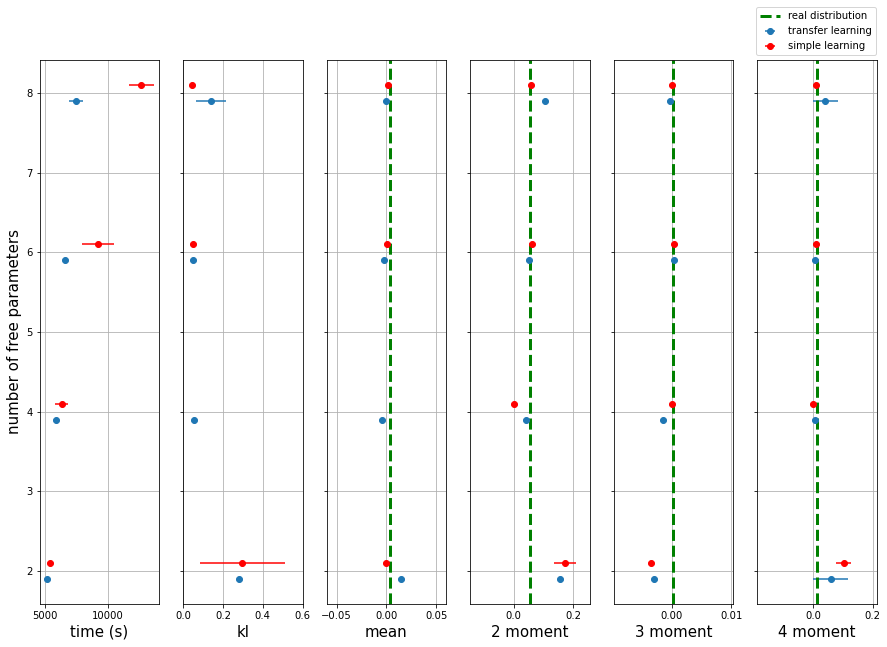

In [20]:
plt.figure(figsize=(15,10))

plt.subplot(1,6,1)
free_params=[8,6,4,2]
disp = 0.1
y_tr = [i-disp for i in free_params]
y_s = [i+disp for i in free_params]
plt.errorbar(moments["time mean (s)"][2:],y_tr,xerr=moments["time error (s)"][2:]/2,fmt="o",label="transfer learning")
plt.errorbar(simple_data["time mean (s)"],y_s,xerr=simple_data["error time (s)"]/2,fmt="o",color="r",label="simple learning")
plt.ylabel("number of free parameters",fontsize = 15)
plt.xlabel("time (s)",fontsize = 15)
#plt.legend()
plt.grid(True)

plt.subplot(1,6,2)
plt.errorbar(moments["kl mean"][2:],y_tr,xerr=moments["kl error"][2:]/2,fmt="o",label="transfer learning")
plt.errorbar(simple_data["kl mean"],y_s,xerr=simple_data["kl error"]/2,fmt="o",c="r",label="simple learning")
#plt.ylabel("free parameters",fontsize = 15)
plt.xlim((0,0.6))
plt.xlabel("kl",fontsize = 15)
ax = plt.gca()
plt.gca().axes.yaxis.set_ticklabels([])
#ax.axes.yaxis.set_visible(False)
#plt.yticks([])
#plt.legend()
plt.grid(True)

#x=["real","fake 10","fake 8 ", "fake 6 ", "fake 4 ","fake 2" ]
free_params=range(8,0,-2)
plt.subplot(1,6,3)
plt.errorbar(moments["mean"][2:], y_tr,xerr=moments["mean error"][2:], fmt="o",label="transfer learning")
plt.errorbar(simple_data["mean"],y_s,xerr=simple_data["mean error"], fmt="o",color="r",label="simple learning")
plt.axvline(x=moments["mean"][0],ls='--', linewidth=3, color='g') 
plt.xlabel("mean",fontsize = 15)
plt.gca().axes.yaxis.set_ticklabels([])
plt.xlim((-0.06,0.06))
#plt.legend()
plt.grid(True)

plt.subplot(1,6,4)

plt.errorbar(moments["2 moment"][2:],y_tr,xerr=moments["2 moment error"][2:], fmt="o",label="transfer learning")
plt.errorbar(simple_data["2 moment"], y_s, xerr=simple_data["2 moment error"], fmt="o", color="r",label="simple learning")
plt.axvline(x=moments["2 moment"][0],ls='--', linewidth=3, color='g') 
plt.xlabel("2 moment",fontsize = 15)
plt.gca().axes.yaxis.set_ticklabels([])
plt.xlim((moments["2 moment"][0]-0.2,moments["2 moment"][0]+0.2))
#plt.legend()
plt.grid(True)

plt.subplot(1,6,5)
plt.errorbar(moments["3 moment"][2:], y_tr,xerr=moments["3 moment error"][2:], fmt="o",label="transfer learning")
plt.errorbar(simple_data["3 moment"], y_s,xerr=simple_data["3 moment error"], fmt="o",color="r",label="simple learning")
plt.axvline(x=moments["3 moment"][0],ls='--', linewidth=3, color='g') 
plt.xlabel("3 moment",fontsize = 15)
plt.gca().axes.yaxis.set_ticklabels([])
plt.xlim((moments["3 moment"][0]-0.01,moments["3 moment"][0]+0.01))
#plt.legend()
plt.grid(True)

plt.subplot(1,6,6)

plt.errorbar(moments["4 moment"][2:], y_tr, xerr=moments["4 moment error"][2:], fmt="o",label="transfer learning")
plt.errorbar(simple_data["4 moment"], y_s,xerr=simple_data["4 moment error"], fmt="o",color="r",label="simple learning")
plt.axvline(x=moments["4 moment"][0],ls='--', linewidth=3, color='g',label="real distribution") 
plt.xlabel("4 moment",fontsize = 15)
plt.gca().axes.yaxis.set_ticklabels([])
plt.xlim((moments["4 moment"][0]-0.2,moments["4 moment"][0]+0.2))

plt.grid(True)
ax = plt.gca()
#ax.legend(loc='upper center')
plt.legend(bbox_to_anchor=(1.04,1), loc="lower right")